In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py



In [2]:
"""
X is stored in a h5 file. 
There are 4400 different samples (90 sec window for each). 
Each sample is made of 8 concatenated signals.
Each signal is 90 sec window, sampled with a 100Hz frequency, ie 9000 values.
(so size of one sample is 9000*8= 72000 values)


- 0: sample index
- 1: subject index
- 2 to 9001: Abdominal belt
- 9002 to 18001: Airflow
- 18002 to 27001: PPG (Photoplethysmogram)
- 27002 to 36001: Thoracic belt
- 36002 to 45001: Snoring indicator
- 45002 to 54001: SPO2
- 54002 to 63001: C4-A1
- 63002 to 72001:O2-A1
"""

X= h5py.File('X_train.h5', 'r')  
print(X.keys())

X=X['data'][:] # convert h5 file to a numpy array
X=X[:,2:] #remove patient id and index (useless)
X.shape

<KeysViewHDF5 ['data']>


(4400, 72000)

In [3]:
# y is, for each of the 4400 samples,  a boolean mask of length 90 sec. "1" means sleeping apnea. "0" means normal sleep

y = pd.read_csv('y_train.csv')
y=y.iloc[:,1:] #remove the index column (useless)
y.shape

(4400, 90)

<AxesSubplot:>

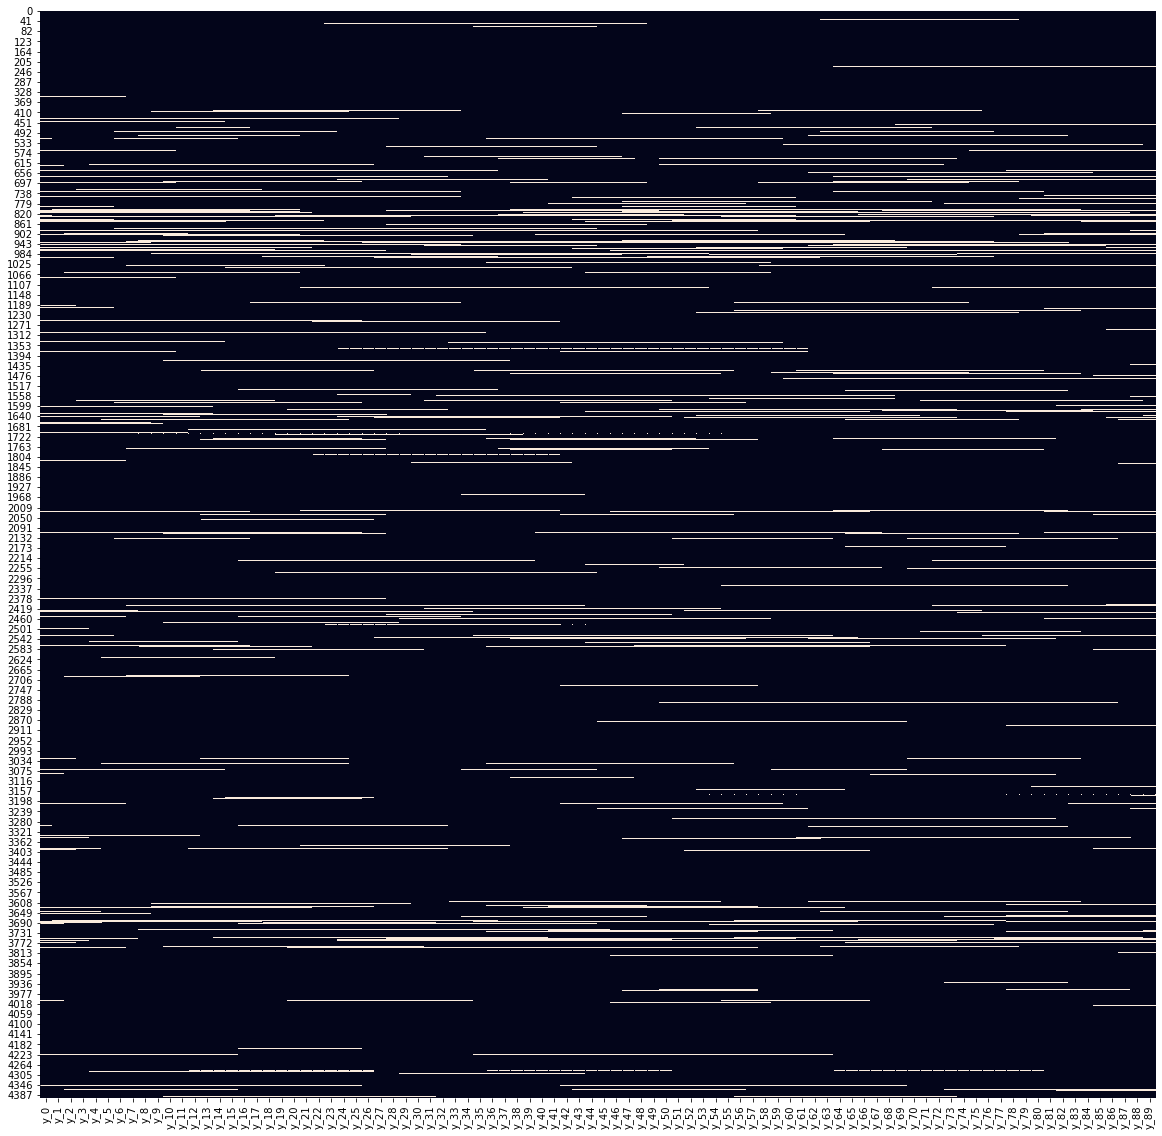

In [4]:
import seaborn as sns               #visualising sleeping apneas spread

plt.figure(figsize=(20,20))
sns.heatmap(y,cbar=False) 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2,random_state=0)                 #splitting the dataset between train set and test set.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3520, 72000)
(3520, 90)
(880, 72000)
(880, 90)


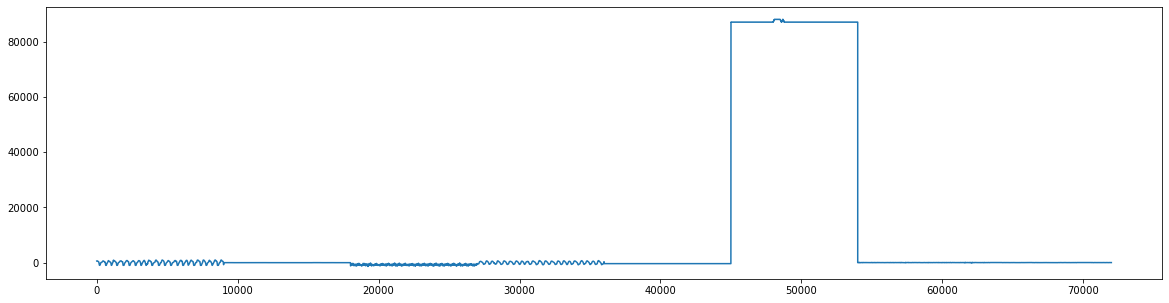

In [11]:
"""BEFORE"""
plt.figure(figsize=(20,5))
plt.plot(X_train[0,:])



In [12]:
from sklearn.preprocessing import StandardScaler

"""BADLY SCALED!!!""" ne tient pas compte des 90s pour un meme signal

scaler=StandardScaler()                                                #scaling the data before the NN for better convergence        
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3520, 72000)
(3520, 90)
(880, 72000)
(880, 90)


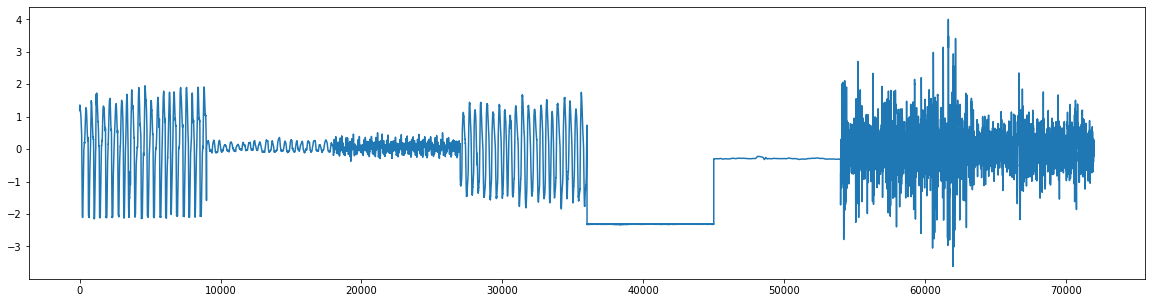

In [13]:
"""AFTER"""
plt.figure(figsize=(20,5))
plt.plot(X_train[0,:])


In [8]:
X_train=X_train.reshape(3520,8,9000) # reshaping the sets because a CNN needs "temporaly coherent" data
X_test=X_test.reshape(880,8,9000)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

#CNN not learning at the moment(...) Clues : kernel badly choosen? input structure? normalization?
#working the subject in stanford deep learning course and back...

model = keras.Sequential([   
    
    layers.BatchNormalization(),#sort of normalization?
#BASE                                          
    layers.Conv1D(filters=128, kernel_size=8 , strides=1 , padding='same', input_shape=(8, 9000)), 
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=256, kernel_size=5 , strides=1 , padding='same'),  
    layers.BatchNormalization(),
    layers.Activation('relu'),


#HEAD
    layers.Flatten(), 
    layers.Dense(90, activation='sigmoid') 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 128)            9216128   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 128)            512       
_________________________________________________________________
activation (Activation)      (None, 8, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 256)            164096    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256)            1024      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 256)            0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [10]:
# cost function : badly choosen? cross entropy on a vector?

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['binary_accuracy'])

In [12]:
record = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=30,
    epochs=3,
)

Epoch 1/3
118/118 [==============================] - 84s 713ms/step - loss: 0.2490 - binary_accuracy: 0.9309 - val_loss: 0.2970 - val_binary_accuracy: 0.9327
Epoch 2/3
118/118 [==============================] - 84s 712ms/step - loss: 0.2508 - binary_accuracy: 0.9309 - val_loss: 0.2845 - val_binary_accuracy: 0.9327
Epoch 3/3
118/118 [==============================] - 84s 711ms/step - loss: 0.2475 - binary_accuracy: 0.9309 - val_loss: 0.2500 - val_binary_accuracy: 0.9327


Best Validation Loss: 0.24995315074920654Best Validation accuracy: 0.9326894879341125


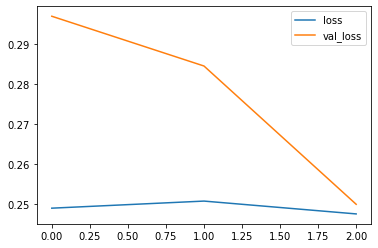

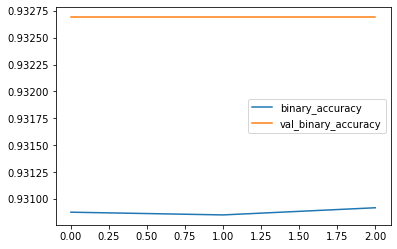

In [13]:
history_df = pd.DataFrame(record.history)

#Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot() 
print(("Best Validation Loss: {}"   + "Best Validation accuracy: {}").format(history_df['val_loss'].min(), 
            history_df['val_binary_accuracy'].min()))

In [14]:
X_train[0:1,:,:].shape

(1, 8, 9000)

(1, 90)


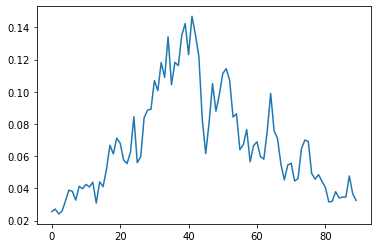

In [15]:
temp = model.predict(X_train[0:1,:,:])
print(temp.shape)
plt.plot(temp.T)

In [17]:
X_true= h5py.File('X_test.h5', 'r') # loading X ground truth set
X_true=X_true['data'][:] 
X_true=X_true[:,2:]
X_true.shape

(4400, 72000)

In [18]:
#X_true=scaler.transform(X_true) #same preprocessing and reshaping
X_true=X_true.reshape(4400,8,9000)
X_true.shape

(4400, 8, 9000)

In [20]:
y_pred = model.predict(X_true)  # our prediction
y_pred.shape

(4400, 90)

<AxesSubplot:>

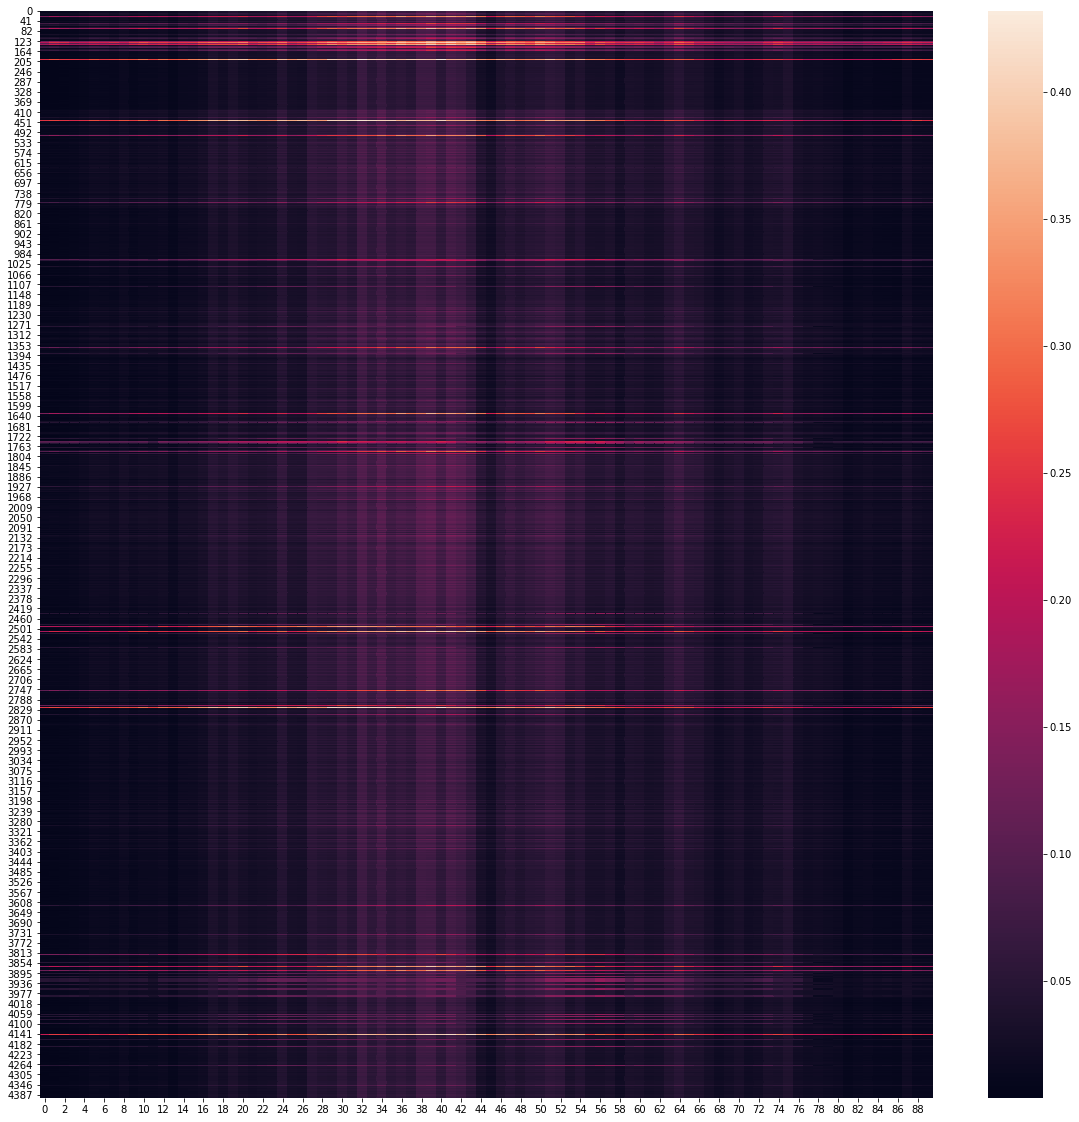

In [21]:
plt.figure(figsize=(20,20)) # visualizing the coherence of our prediction
sns.heatmap(y_pred)

In [22]:
y_submission = pd.read_csv('y_benchmark.csv') # prediction converted into the right format
y_submission



,ID,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,...,y_80,y_81,y_82,y_83,y_84,y_85,y_86,y_87,y_88,y_89
0,4400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4401,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4402,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,4403,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4404,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,8795,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4396,8796,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4397,8797,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4398,8798,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

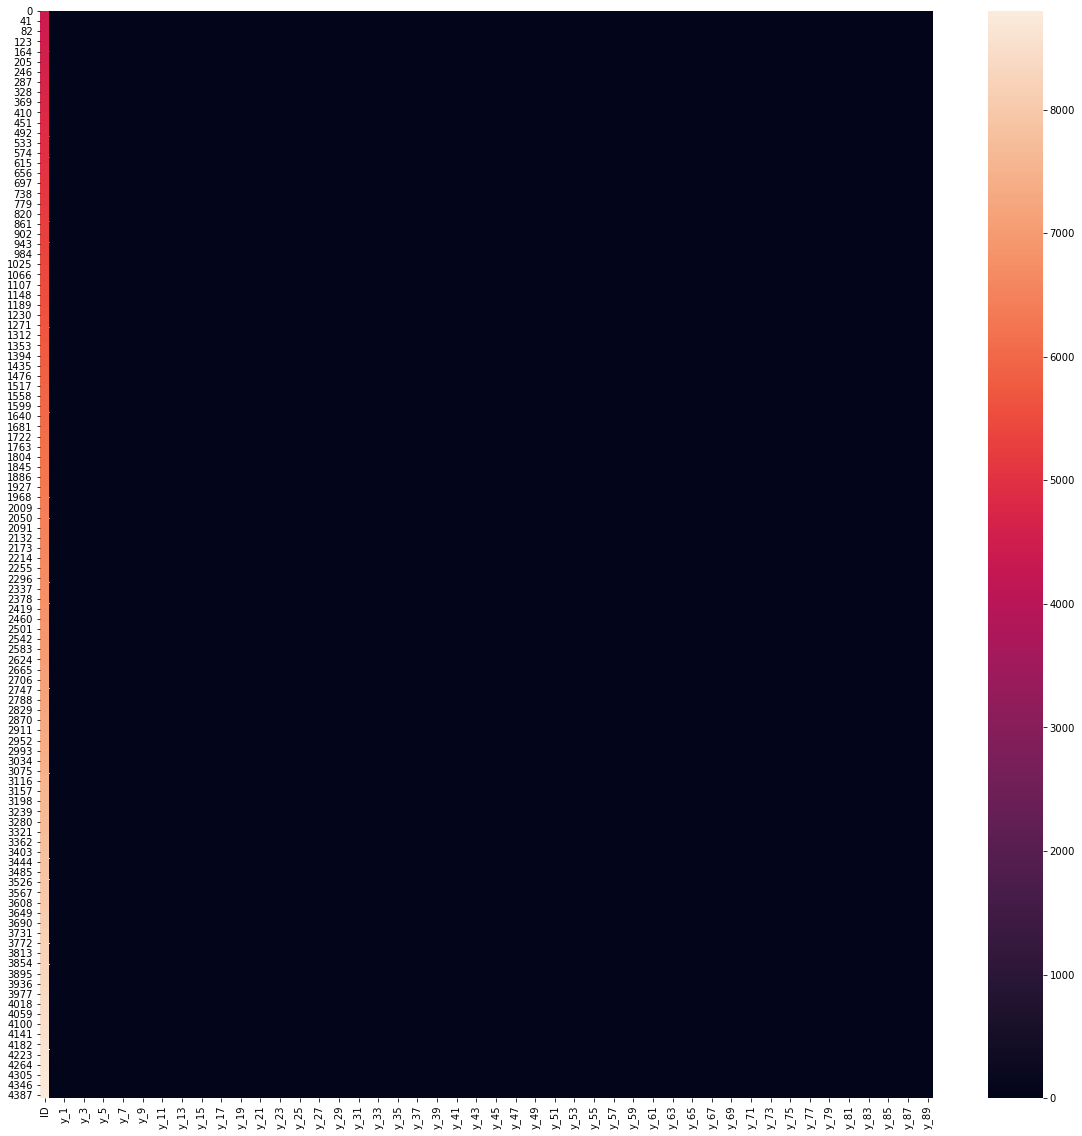

In [24]:
for i in range(y_pred.shape[0]):
    for j in range(y_pred.shape[1]):
        if y_pred[i,j]>0.5:          
            
            y_submission.iloc[i,j+1]=1
        else :
            y_submission.iloc[i,j+1]=0



<AxesSubplot:>

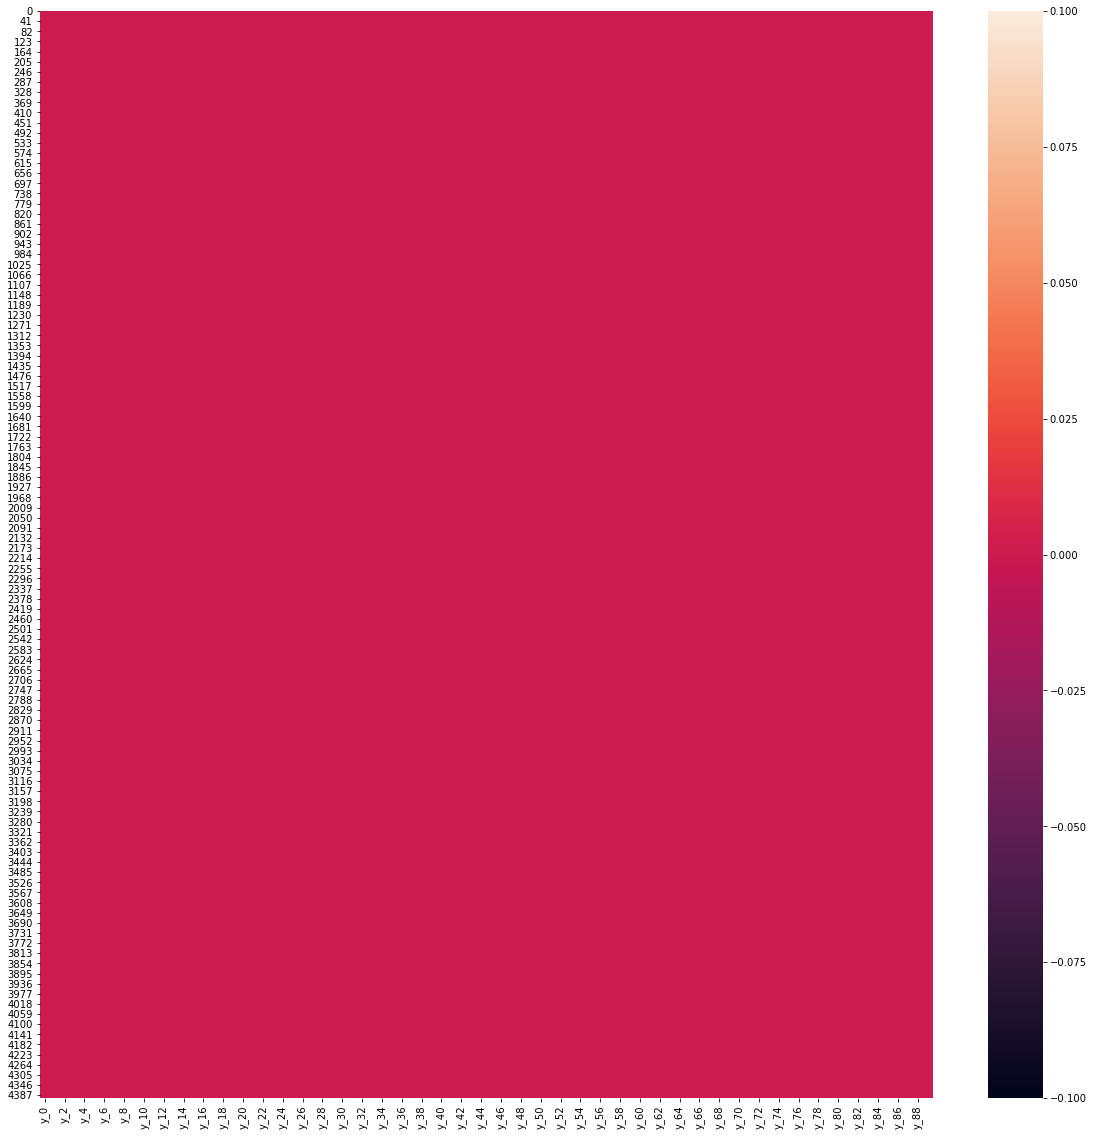

In [26]:
plt.figure(figsize=(20,20)) # visualizing the coherence of our prediction
sns.heatmap(y_submission.iloc[:,1:])

In [ ]:
# exporting our answer
y_submission.to_csv('essai de prediction1.csv' ,index=False)

# PERSONNAL NOTES, DO NOT READ


In [1]:
SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]


def extract_events_from_binary_mask(binary_mask, fs=1):
    binary_mask = np.array([0] + binary_mask.tolist() + [0])
    diff_data = np.diff(binary_mask)
    starts = np.where(diff_data == 1)[0] / fs
    ends = np.where(diff_data == -1)[0] / fs

    assert len(starts) == len(ends)
    events = []
    for i, _ in enumerate(starts):
        events += [(starts[i], ends[i])]

    return events


def visualize_signal_and_event(X, mask, signals_name=SIGNALS_NAME, signal_freq=100):
    n_signal = X.shape[0]
    fig, axs = plt.subplots(n_signal, sharex=True)
    events = extract_events_from_binary_mask(mask)
    for i in range(n_signal):
        axs[i].plot(np.arange(0, X[i].shape[0]) / signal_freq, X[i])
        axs[i].set_ylabel(signals_name[i])
        for elt in events:
            axs[i].axvspan(elt[0], elt[1], color='red', alpha=0.3)
    plt.xlim(0, X[0].shape[0]/ signal_freq)
    plt.show()


def visualise_index(idx, data_h5, masks, N_signals=8):
    x = data_h5['data'][idx, 2:]
    x = x.reshape(N_signals, -1)
    visualize_signal_and_event(x, np.array(masks[idx, 1:]))


if __name__ == "__main__":
    import h5py
    PATH_TO_TRAINING_DATA = "C:\\Users\\pierr\\DREEM PROJECT\\X_train.h5"
    PATH_TO_TRAINING_TARGET = "C:\\Users\\pierr\\DREEM PROJECT\y_train.csv"
    h5_file = h5py.File(PATH_TO_TRAINING_DATA)
    mask = np.array(pd.read_csv(PATH_TO_TRAINING_TARGET))
    visualise_index(18, h5_file, mask)

<ipython-input-1-b8642c03e2ad>:50: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5_file = h5py.File(PATH_TO_TRAINING_DATA)


OSError: Unable to create file (unable to open file: name = 'C:\Users\pierr\DREEM PROJECT\X_train.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = 502)